## Correlation: &thinsp; DOC and specific humidity (hus)

In [33]:
import xarray as xr
import numpy as np
import skimage.measure as skm
import pandas as pd
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from os.path import expanduser
home = expanduser("~")

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [34]:
from myFuncs import *

In [35]:
plt.rcParams['figure.figsize'] = [10, 7.5]

### one dataset

In [36]:
variable = 'hus'

data_options= [
    'hus'
    ]

org_options= [
    'rome'
    # 'ni'
    ]

models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3 no wap data
    # 'bcc-csm1-1',   # 4 no wao rcp
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 no wap data
    # 'HadGEM2-AO',   # 7 no wap data, no hus rcp data
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9 no wap data, no hus
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13 no wap data
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17 no wap data
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19 no wap data, no hus data
    ]

observations = [
    ]

datasets = models + observations

resolutions = [
    # 'original',
    'regridded'
    ]

experiments = [
    'historical',
    # 'rcp85'
    ]


print('variable:{}, dataset:{}, experiment:{}, resolution:{}'.format(variable, datasets[0], experiments[0], resolutions[0]))
ds = get_dsvariable(variable, datasets[0], experiment= experiments[0], resolution=resolutions[0])
ds

variable:hus, dataset:GFDL-CM3, experiment:historical, resolution:regridded


<xarray.Dataset>
Dimensions:  (plev: 8, time: 10950, lat: 22, lon: 128)
Coordinates:
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    hus      (time, plev, lat, lon) float32 ...

In [37]:
data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
g = 9.8
data = xr.DataArray(
    data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
    dims=['time', 'lat', 'lon'],
    coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
    attrs={'units':'mm'}
    )
data

<xarray.DataArray (time: 10950, lat: 22, lon: 128)>
array([[[ 5.76216501,  5.44602681,  4.991741  , ...,  7.86523546,
          6.90641754,  6.22673042],
        [ 8.31526368,  8.8052164 ,  9.02521954, ...,  8.19560539,
          7.91285742,  7.90662002],
        [15.99003847, 16.45197091, 17.21483989, ..., 11.59789954,
         13.61265104, 15.25914329],
        ...,
        [ 4.66451587,  4.09163833,  3.4771078 , ...,  2.45608692,
          2.93883191,  4.03722273],
        [ 4.26762126,  6.27211626,  6.97203773, ...,  1.74542123,
          1.83418615,  2.35240756],
        [ 2.39699442,  3.24790328,  5.03179055, ...,  1.92955799,
          2.25597872,  2.30381386]],

       [[ 4.2690278 ,  4.07056536,  4.19746519, ...,  6.54440207,
          5.49658298,  4.76271063],
        [ 4.29827345,  3.84108626,  3.58086838, ...,  9.17895833,
          6.50681498,  5.05923288],
        [ 7.38958705,  5.72041239,  4.74298895, ..., 15.12213272,
         12.43853849,  9.7127485 ],
...
        [ 3.90698252,  4.40583627,  5.39542098, ...,  3.98183331,
          3.99536732,  3.94192035],
        [ 4.75875473,  5.23744382,  6.02445904, ...,  4.75113738,
          4.73768054,  4.6971823 ],
        [ 6.52724359,  7.22299192,  7.71626066, ...,  6.64361573,
          6.4622822 ,  6.30746217]],

       [[ 6.31741539,  5.33107778,  4.42343602, ...,  9.8917893 ,
          9.66871366,  7.86931776],
        [ 6.53068697,  5.95489952,  5.09926019, ...,  9.28482263,
          8.72559568,  7.37372762],
        [ 5.89028955,  5.24951448,  4.43445228, ...,  7.90073292,
          7.31742848,  6.5502004 ],
        ...,
        [ 3.87091778,  3.74853896,  3.99523811, ...,  4.08585031,
          4.04839478,  4.05651063],
        [ 4.52979138,  4.58335895,  4.66473855, ...,  4.62042484,
          4.43440707,  4.43888307],
        [ 4.65914735,  5.01783413,  5.32407169, ...,  3.49160164,
          3.85523348,  4.21318903]]])
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    units:    mm

In [38]:
org = get_metric(org_options[0], datasets[0], experiments[0], resolution=resolutions[0])[org_options[0]]
org

<xarray.DataArray 'rome' (time: 10950)>
array([ 683534.434225,  880457.953047,  817436.978227, ..., 1267915.787371,
        827632.541006,  978485.728019])
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Attributes:
    units:    km^2

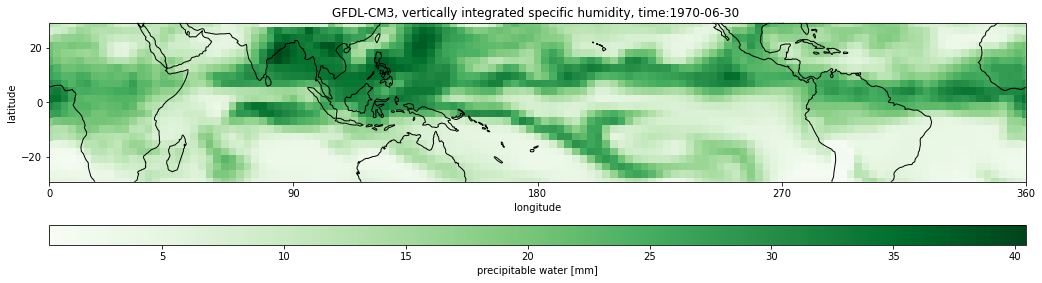

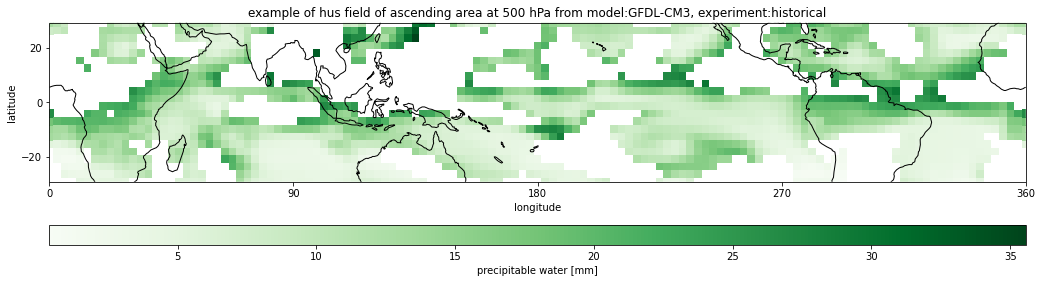

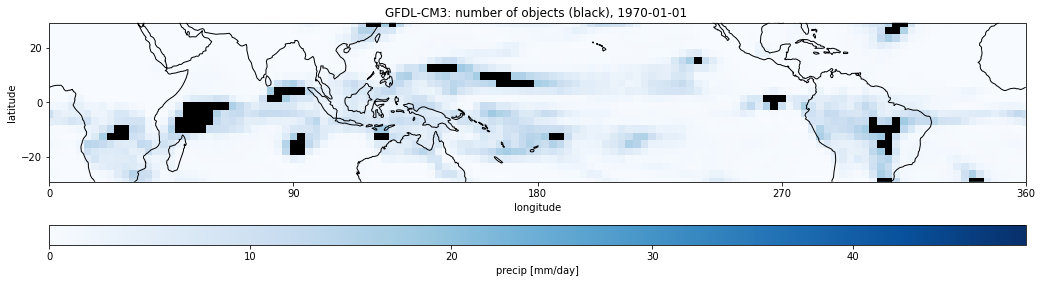

In [39]:
fig= plt.figure(figsize=(17.5,8))
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

scene = data.isel(time=180)

lat = scene.lat
lon = scene.lon
lonm,latm = np.meshgrid(lon,lat)

ax.add_feature(cartopy.feature.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Greens', vmin=None, vmax=None)
ax.set_title(datasets[0] + ', vertically integrated specific humidity, time:' + str(scene.coords['time'].values)[:11] )
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'precipitable water' + ' [{}]'.format(scene.attrs['units']))


hus_d = True
if hus_d:
    wap500 = get_dsvariable('wap', datasets[0], experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
    data = data.where(wap500>0, np.nan)
    scene = data.isel(time=180)

    title = 'example of {} field of ascending area at 500 hPa from model:{}, experiment:{}'.format(variable, datasets[0], experiments[0])
    fig= plt.figure(figsize=(17.5,8))
    ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

    lat = scene.lat
    lon = scene.lon
    lonm,latm = np.meshgrid(lon,lat)

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

    pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Greens', vmin=None, vmax=None)
    ax.set_title(title)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')

    ax.set_yticks([-20, 0, 20])
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])

    plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'precipitable water' + ' [{}]'.format(scene.attrs['units']))



scene = get_dsvariable('precip', datasets[0],experiments[0],home, resolutions[0])['precip'].isel(time=0)
conv_threshold = get_metric('prPercentiles', datasets[0], experiments[0])['pr97'].mean(dim=('time'))

lat = scene.lat
lon = scene.lon
lonm,latm = np.meshgrid(lon,lat)

obj = skm.label(scene.where(scene>=conv_threshold,0)>0, background=np.nan,connectivity=2)
obj = (obj>0)*1
labelMatrix = xr.DataArray(
    data=obj,
    dims=['lat', 'lon'],
    coords={'lat': scene.lat.data, 'lon': scene.lon.data}
    )
obj = labelMatrix.where(labelMatrix>0)


fig= plt.figure(figsize=(17.5,8))
ax = fig.add_subplot(projection=cartopy.crs.PlateCarree(central_longitude=180))

ax.add_feature(cartopy.feature.COASTLINE)
ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=cartopy.crs.PlateCarree())

pcm = ax.pcolormesh(lonm,latm, scene,transform=cartopy.crs.PlateCarree(),zorder=0, cmap='Blues') #, vmin=10, vmax=50)
ax.pcolormesh(lonm,latm, obj,transform=cartopy.crs.PlateCarree(), cmap='Greys_r')

ax.set_title(datasets[0] + ': number of objects (black), ' + str(scene.coords['time'].values)[:11] )
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_yticks([-20, 0, 20])
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_xticklabels([0, 90, 180, 270, 360])

plt.colorbar(pcm, ax=ax, orientation='horizontal',pad=0.10, aspect=50, fraction=0.055, label = 'precip' + ' [mm/day]')
plt.show()

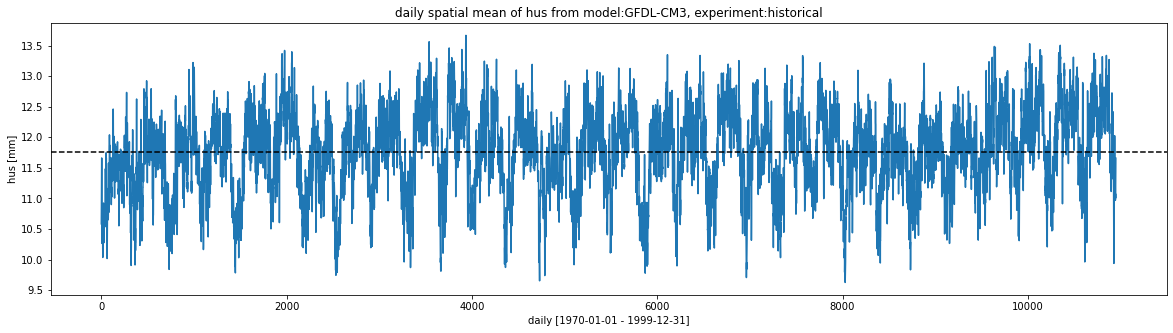

In [40]:
timeMean_options = [
    # 'annual',
    # 'seasonal',
    # 'monthly',
    'daily'
    ]

aWeights = np.cos(np.deg2rad(data.lat))
y = data.weighted(aWeights).mean(dim=('lat','lon')) 
y = resample_timeMean(y, timeMean_options[0])
title = '{} spatial mean of {} from model:{}, experiment:{}'.format(timeMean_options[0], data_options[0], datasets[0], experiments[0])
xlabel = '{} [{} - {}]'.format(timeMean_options[0], str(data.isel(time=0).coords['time'].values)[:10], str(data.isel(time=-1).coords['time'].values)[:10])
ylabel = '{} [{}]'.format(data_options[0], data.units)


plot_timeseries(y, title=title, timeMean_option=timeMean_options)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

if timeMean_options[0]=='seasonal':
    plt.legend()

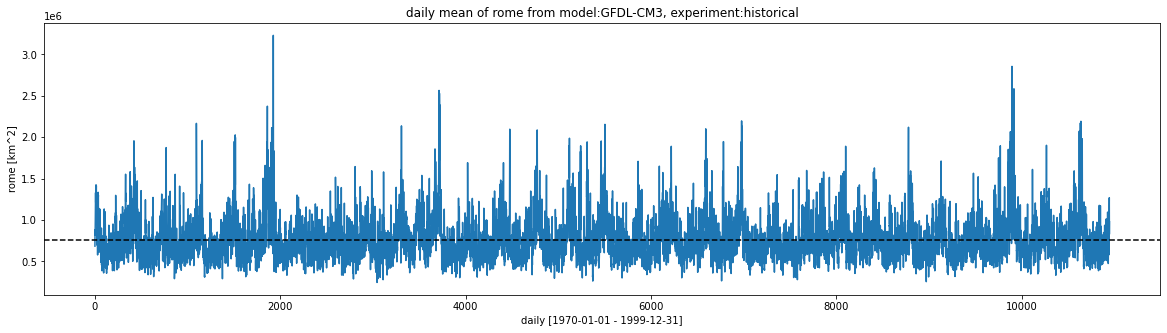

In [41]:
timeMean_options = [
    # 'annual',
    # 'seasonal',
    # 'monthly',
    'daily'
    ]

x = resample_timeMean(org, timeMean_options[0])
title = '{} mean of {} from model:{}, experiment:{}'.format(timeMean_options[0], org_options[0], datasets[0], experiments[0])
xlabel = '{} [{} - {}]'.format(timeMean_options[0], str(data.isel(time=0).coords['time'].values)[:10], str(data.isel(time=-1).coords['time'].values)[:10])
ylabel = '{} [{}]'.format(org_options[0], org.units)


plot_timeseries(x, timeMean_option=timeMean_options[0],title=title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

if timeMean_options[0]=='seasonal':
    plt.legend()

### correlation in scenario

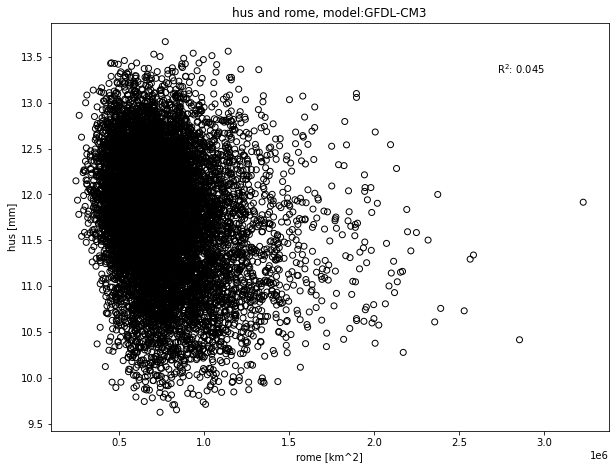

In [42]:
timeMean_options = [
    # 'annual',
    # 'monthly',
    'daily'
    ]

x = resample_timeMean(org, timeMean_options[0])
aWeights = np.cos(np.deg2rad(data.lat))
y = data.weighted(aWeights).mean(dim=('lat','lon')) 
y = resample_timeMean(y, timeMean_options[0])

fig = plt.figure()
ax= fig.add_subplot()
plot_scatter(x, y, ax)
plt.title('{} and {}, model:{}'.format(data_options[0], org_options[0], datasets[0]))
plt.xlabel('{} [{}]'.format(org_options[0], org.units))
plt.ylabel('{} [{}]'.format(data_options[0], data.units))
plt.show()

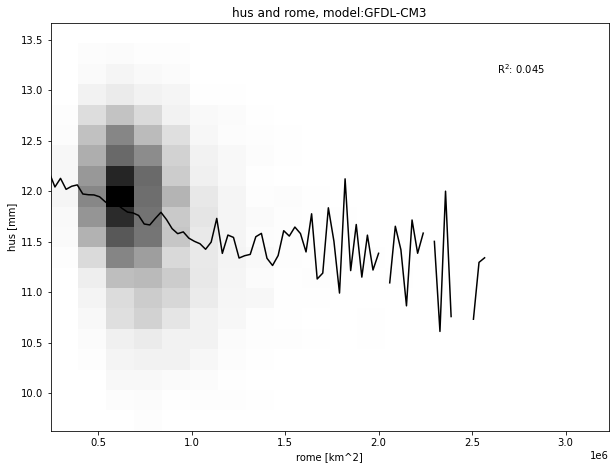

In [43]:
timeMean_options = [
    # 'annual',
    # 'monthly',
    'daily'
    ]

x = resample_timeMean(org, timeMean_options[0])
aWeights = np.cos(np.deg2rad(data.lat))
y = data.weighted(aWeights).mean(dim=('lat','lon')) 
y = resample_timeMean(y, timeMean_options[0])

fig = plt.figure()
ax= fig.add_subplot()

plt.hist2d(x,y,[20,20], cmap ='Greys') #, vmin=0, vmax=300)
plot_bins(x,y, ax)

plt.title('{} and {}, model:{}'.format(data_options[0], org_options[0], datasets[0]))
plt.xlabel('{} [{}]'.format(org_options[0], org.units))
plt.ylabel('{} [{}]'.format(data_options[0], data.units))
plt.show()

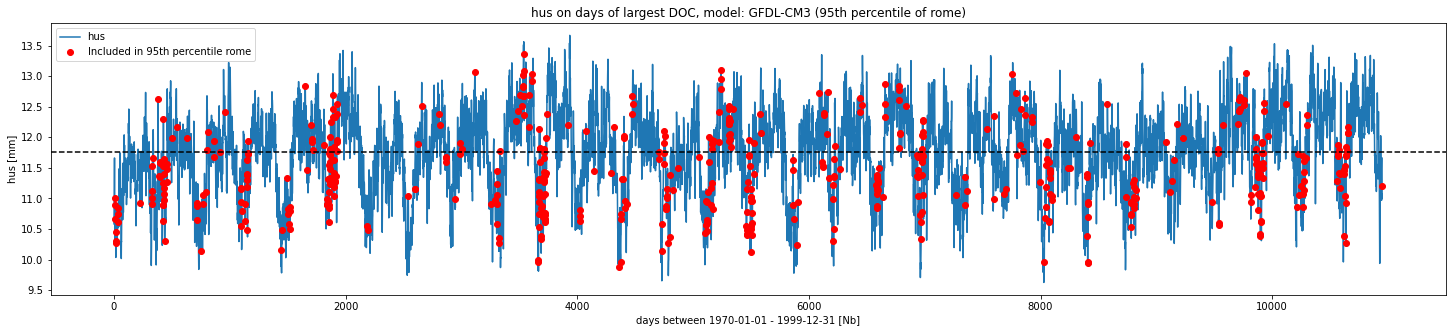

In [44]:
timeMean_options = [
    # 'annual',
    # 'monthly',
    'daily'
    ]

x = org
aWeights = np.cos(np.deg2rad(data.lat))
y = data.weighted(aWeights).mean(dim=('lat','lon')) 
y = resample_timeMean(y, timeMean_options[0])

x_threshold = 95
x_prctile = np.percentile(x, x_threshold)
x_org= np.squeeze(np.argwhere(x.data>=x_prctile)) # positive anomalies are where DOC exceed the monthly mean

x_data= np.arange(0,len(y))

f, ax = plt.subplots(figsize = (25,5))
title = 'hus on days of largest DOC, model: {} ({}th percentile of {})'.format(datasets[0], str(x_threshold), org_options[0])
label = 'Included in {}th percentile {}'.format(str(x_threshold), org_options[0])

ax.plot(x_data,y, zorder=0,label=data_options[0])
ax.scatter(x_org, y[x_org], label=label, color='r')
ax.axhline(y=np.mean(y), color='k', linestyle = '--')
ax.set_title(title)


ax.set_xlabel('days between ' + str(data.coords['time'][0].values)[:10] 
              +' - '+ str(data.coords['time'][-1].values)[:10] + ' [Nb]')
ax.set_ylabel('{} [{}]'.format(data_options[0], data.units))
ax.legend()

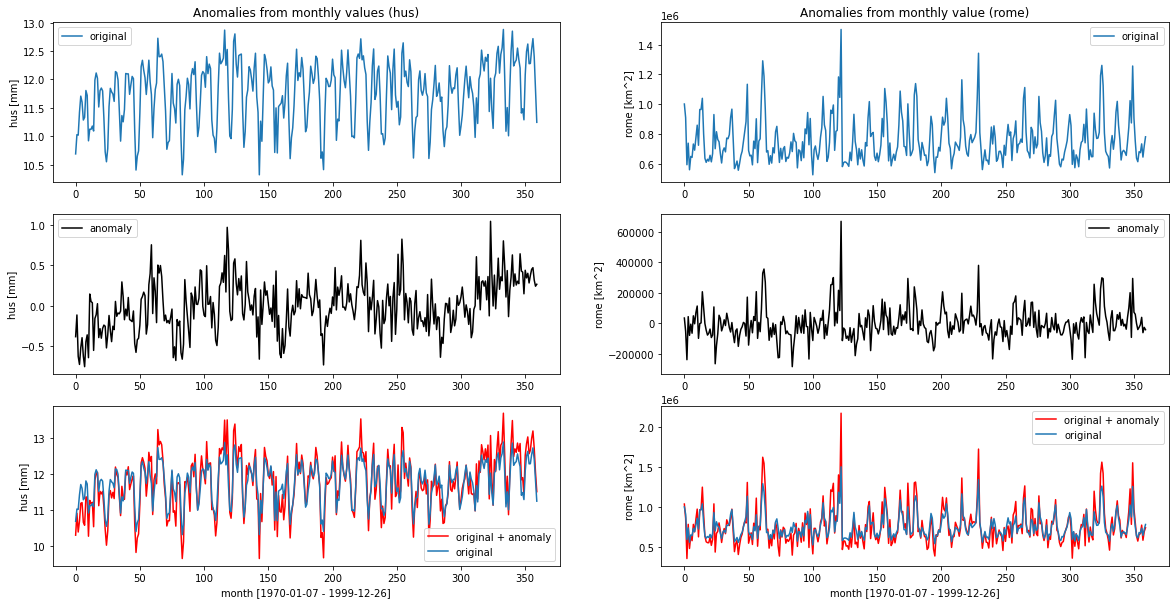

In [45]:
aWeights = np.cos(np.deg2rad(data.lat))
f = data.weighted(aWeights).mean(dim=('lat','lon')) 
f = f.resample(time='M').mean(dim='time')
climatology = f.groupby('time.month').mean('time')
data_anomalies_month = f.groupby('time.month') - climatology 

fig, axs = plt.subplots(3,2,figsize=(20,10))

xlabel = '{} [{} - {}]'.format('month', str(data.isel(time=6).coords['time'].values)[:10], str(data.isel(time=-6).coords['time'].values)[:10])
ylabel = '{} [{}]'.format(data_options[0], data.units)

plt.sca(axs[0, 0])
plt.plot(f, label='original')
plt.ylabel(ylabel)
plt.title('Anomalies from monthly values ({})'.format(data_options[0]))
plt.legend()

plt.sca(axs[1,0])
plt.plot(data_anomalies_month, 'k', label='anomaly')
plt.ylabel(ylabel)
plt.legend()

plt.sca(axs[2,0])
plt.plot(f+data_anomalies_month,color='r', label='original + anomaly')
plt.plot(f, label='original')
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.legend()

f = org.resample(time='M').mean(dim='time')
climatology = f.groupby('time.month').mean('time')
org_anomalies_month = f.groupby('time.month') - climatology 

xlabel = '{} [{} - {}]'.format('month', str(data.isel(time=6).coords['time'].values)[:10], str(data.isel(time=-6).coords['time'].values)[:10])
ylabel = '{} [{}]'.format(org_options[0], org.units)

plt.sca(axs[0, 1])
plt.plot(f, label='original')
plt.ylabel(ylabel)
plt.title('Anomalies from monthly value ({})'.format(org_options[0]))
plt.legend()

plt.sca(axs[1,1])
plt.plot(org_anomalies_month, 'k', label='anomaly')
plt.ylabel(ylabel)
plt.legend()

plt.sca(axs[2,1])
plt.plot(f+org_anomalies_month,color='r', label='original + anomaly')
plt.plot(f, label='original')
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.legend()
plt.show()

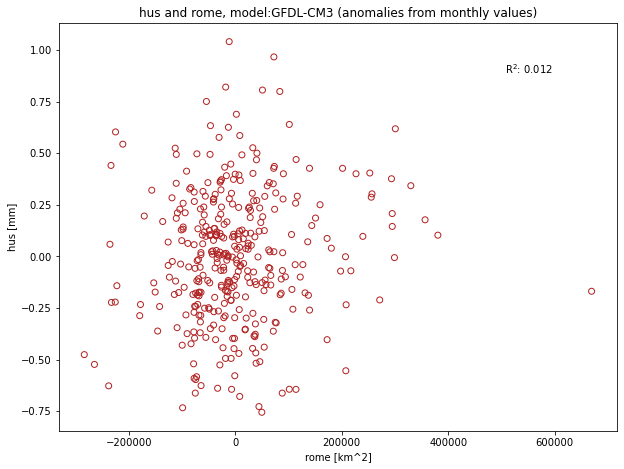

In [46]:
timeMean_options = [
    'monthly'
    ]

f = resample_timeMean(org, timeMean_options[0])
climatology = f.groupby('time.month').mean('time')
x = f.groupby('time.month') - climatology 

aWeights = np.cos(np.deg2rad(data.lat))
f = data.weighted(aWeights).mean(dim=('lat','lon')) 
f = resample_timeMean(f, timeMean_options[0])
climatology = f.groupby('time.month').mean('time')
y = f.groupby('time.month') - climatology 


fig = plt.figure()
ax= fig.add_subplot()
plot_scatter(x, y, ax, 'firebrick')
plt.title('{} and {}, model:{} (anomalies from monthly values)'.format(data_options[0], org_options[0], datasets[0]))
plt.xlabel('{} [{}]'.format(org_options[0], org.units))
plt.ylabel('{} [{}]'.format(data_options[0], data.units))
plt.show()

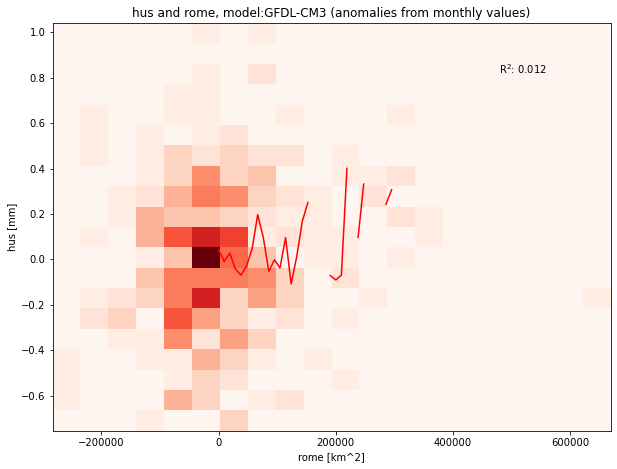

In [47]:
timeMean_options = [
    # 'annual',
    'monthly',
    # 'daily'
    ]

f = resample_timeMean(org, timeMean_options[0])
climatology = f.groupby('time.month').mean('time')
x = f.groupby('time.month') - climatology 

aWeights = np.cos(np.deg2rad(data.lat))
f = data.weighted(aWeights).mean(dim=('lat','lon')) 
f = resample_timeMean(f, timeMean_options[0])
climatology = f.groupby('time.month').mean('time')
y = f.groupby('time.month') - climatology 


fig = plt.figure()
ax= fig.add_subplot()

plt.hist2d(x,y,[20,20], cmap = 'Reds') #, vmin=0, vmax=300)
plot_bins(x,y, ax, 'r')

plt.title('{} and {}, model:{} (anomalies from monthly values)'.format(data_options[0], org_options[0], datasets[0]))
plt.xlabel('{} [{}]'.format(org_options[0], org.units))
plt.ylabel('{} [{}]'.format(data_options[0], data.units))
plt.show()

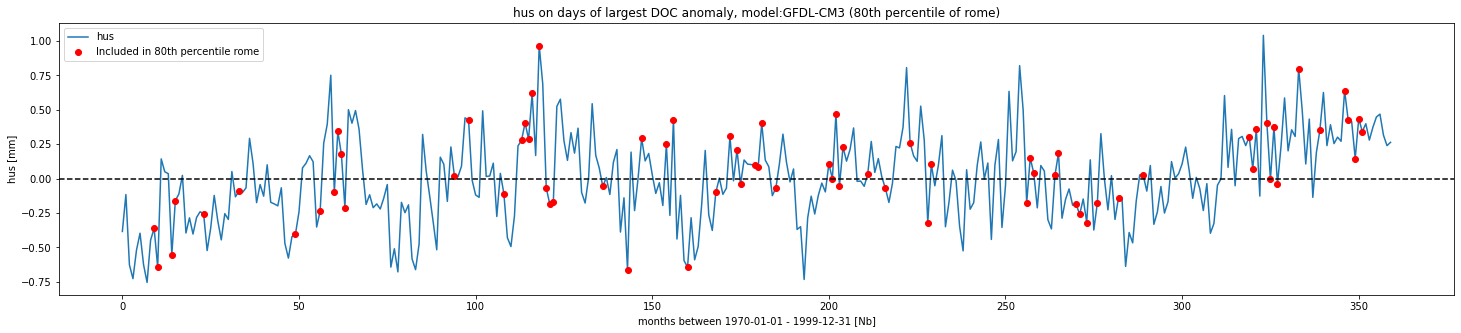

In [48]:
timeMean_options = [
    # 'annual',
    'monthly',
    # 'daily'
    ]

f = resample_timeMean(org, timeMean_options[0])
climatology = f.groupby('time.month').mean('time')
x = f.groupby('time.month') - climatology 

aWeights = np.cos(np.deg2rad(data.lat))
f = data.weighted(aWeights).mean(dim=('lat','lon')) 
f = resample_timeMean(f, timeMean_options[0])
climatology = f.groupby('time.month').mean('time')
y = f.groupby('time.month') - climatology 


x_threshold = 80
x_prctile = np.percentile(x, x_threshold)
x_org= np.squeeze(np.argwhere(x.data>=x_prctile)) # positive anomalies are where DOC exceed the monthly mean

x_data= np.arange(0,len(y))

f, ax = plt.subplots(figsize = (25,5))
title = 'hus on days of largest DOC anomaly, model:{} ({}th percentile of {})'.format(datasets[0], str(x_threshold), org_options[0])
label = 'Included in {}th percentile {}'.format(str(x_threshold), org_options[0])

ax.plot(x_data,y, zorder=0,label=data_options[0])
ax.scatter(x_org, y[x_org], label=label, color='r')
ax.axhline(y=np.mean(y), color='k', linestyle = '--')
ax.set_title(title)


ax.set_xlabel('months between ' + str(data.coords['time'][0].values)[:10] 
              +' - '+ str(data.coords['time'][-1].values)[:10] + ' [Nb]')
ax.set_ylabel('{} [{}]'.format(data_options[0], data.units))
ax.legend()

### comparing datasets

In [49]:
models = [
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3 no wap data
    'bcc-csm1-1',   # 4 no wao rcp
    'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 no wap data
    # 'HadGEM2-AO',   # 7 no wap data, no hus rcp data
    'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9 no wap data, no hus
    'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    'CMCC-CM',      # 12
    # 'inmcm4',       # 13 no wap data
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17 no wap data
    'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19 no wap data, no hus data
    ]

observations = [
    ]

datasets = models + observations

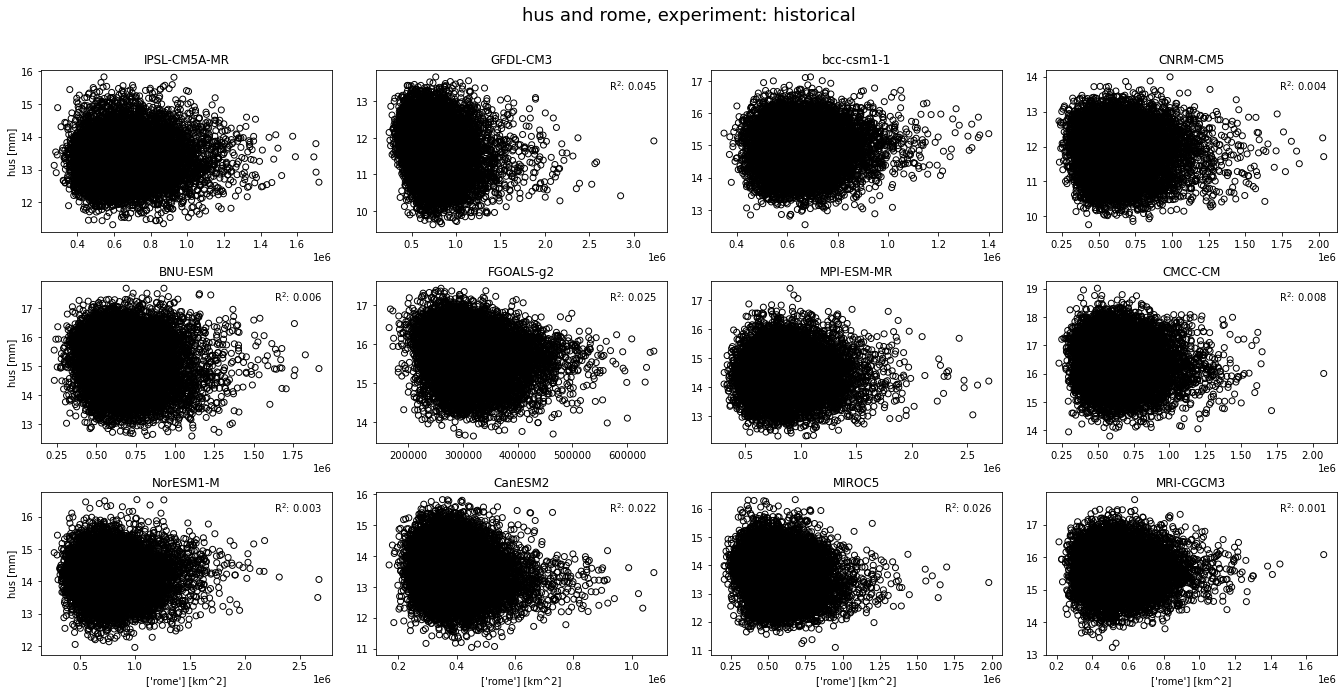

In [50]:
timeMean_options = [
    # 'annual',
    # 'monthly',
    'daily'
    ]

quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:

        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        x = resample_timeMean(org, timeMean_options[0])

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))

    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:

        ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
        data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
        g = 9.8
        data = xr.DataArray(
            data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
            dims=['time', 'lat', 'lon'],
            coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
            attrs={'units':'mm'}
            )
        
        if hus_d:
            wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
            data = data.where(wap500>0, np.nan)

        aWeights = np.cos(np.deg2rad(data.lat))
        y = data.weighted(aWeights).mean(dim=('lat','lon')) 
        y = resample_timeMean(y, timeMean_options[0])

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))

    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} and {}, experiment: {}'.format(data_options[0], org_options[0], experiments[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    x = resample_timeMean(org, timeMean_options[0])


    ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
    data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
    g = 9.8
    data = xr.DataArray(
        data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
        dims=['time', 'lat', 'lon'],
        coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
        attrs={'units':'mm'}
        )
    
    if hus_d:
        wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
        data = data.where(wap500>0, np.nan)

    aWeights = np.cos(np.deg2rad(data.lat))
    y = data.weighted(aWeights).mean(dim=('lat','lon')) 
    y = resample_timeMean(y, timeMean_options[0])

    plot_scatter(x, y , ax)
    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{}]'.format(org_options, org.units)
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], data.units)
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

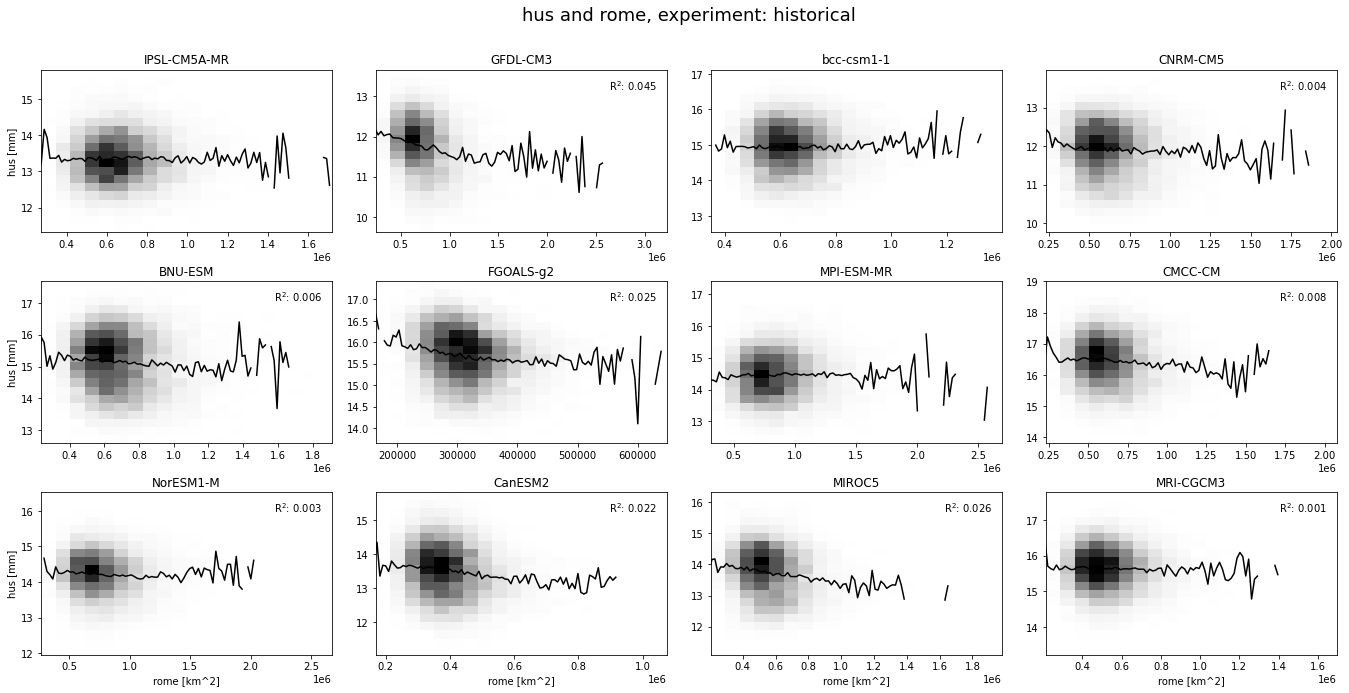

In [51]:
timeMean_options = [
    # 'annual',
    # 'monthly',
    'daily'
    ]

quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:

        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        x = resample_timeMean(org, timeMean_options[0])

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))

    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:

        ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
        data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
        g = 9.8
        data = xr.DataArray(
            data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
            dims=['time', 'lat', 'lon'],
            coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
            attrs={'units':'mm'}
            )
        
        if hus_d:
            wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
            data = data.where(wap500>0, np.nan)

        aWeights = np.cos(np.deg2rad(data.lat))
        y = data.weighted(aWeights).mean(dim=('lat','lon')) 
        y = resample_timeMean(y, timeMean_options[0])

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))

    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} and {}, experiment: {}'.format(data_options[0], org_options[0], experiments[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    x = resample_timeMean(org, timeMean_options[0])


    ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
    data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
    g = 9.8
    data = xr.DataArray(
        data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
        dims=['time', 'lat', 'lon'],
        coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
        attrs={'units':'mm'}
        )
    
    if hus_d:
        wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
        data = data.where(wap500>0, np.nan)

    aWeights = np.cos(np.deg2rad(data.lat))
    y = data.weighted(aWeights).mean(dim=('lat','lon')) 
    y = resample_timeMean(y, timeMean_options[0])

    plt.hist2d(x,y,[20,20], cmap ='Greys') #, vmin=0, vmax=300)
    plot_bins(x,y, ax)


    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{}]'.format(org_options[0], org.units)
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], data.units)
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

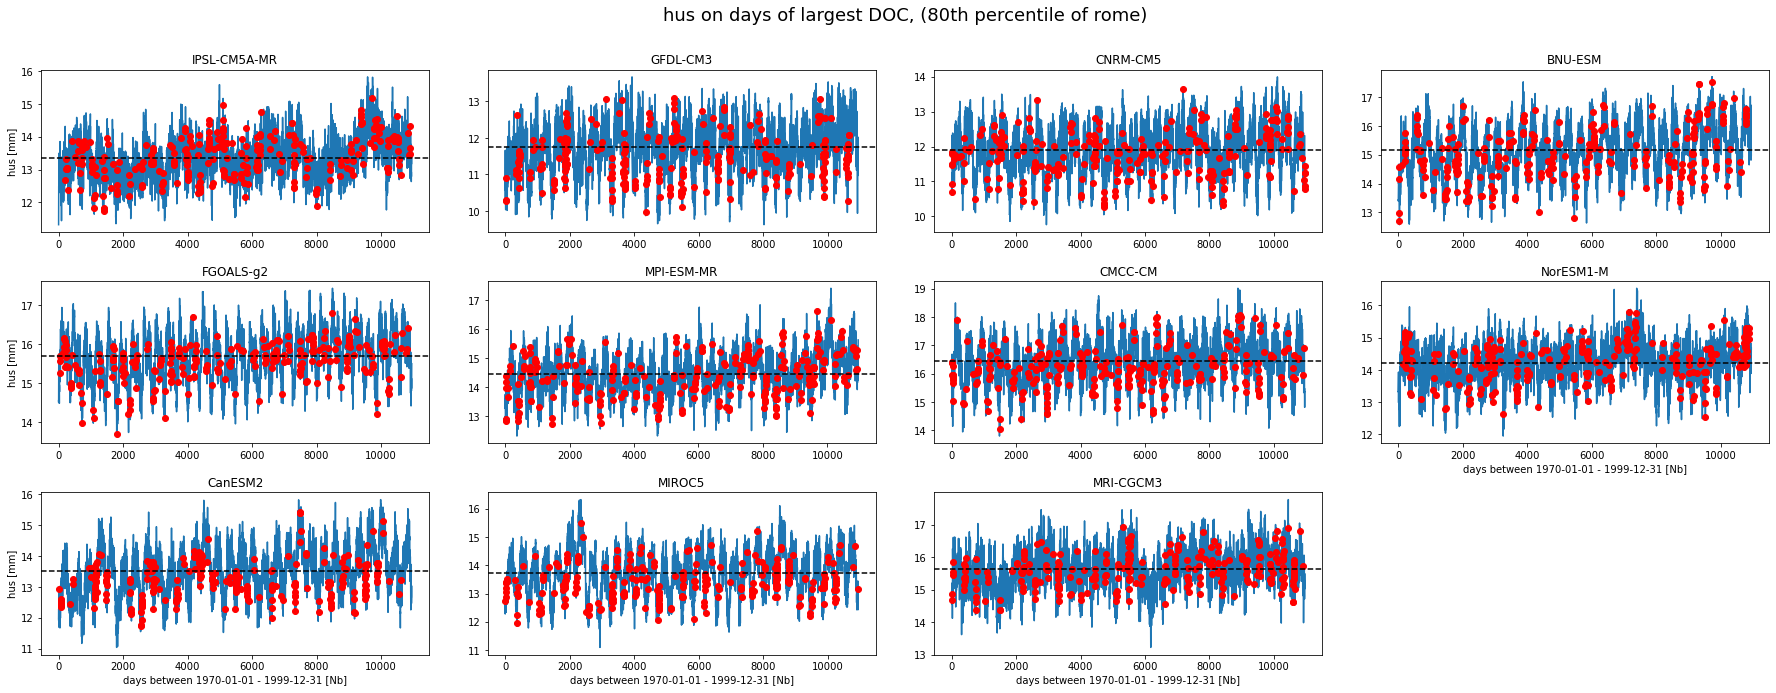

In [63]:
timeMean_options = [
    # 'annual',
    # 'monthly',
    'daily'
    ]

quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:

        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        x = resample_timeMean(org, timeMean_options[0])

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))

    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:

        ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
        data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
        g = 9.8
        data = xr.DataArray(
            data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
            dims=['time', 'lat', 'lon'],
            coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
            attrs={'units':'mm'}
            )
        
        if hus_d:
            wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
            data = data.where(wap500>0, np.nan)

        aWeights = np.cos(np.deg2rad(data.lat))
        y = data.weighted(aWeights).mean(dim=('lat','lon')) 
        y = resample_timeMean(y, timeMean_options[0])

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))

    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(30,17.5))
title = 'hus on days of largest DOC, ({}th percentile of {})'.format(str(x_threshold), org_options[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    x = resample_timeMean(org, timeMean_options[0])


    ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
    data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
    g = 9.8
    data = xr.DataArray(
        data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
        dims=['time', 'lat', 'lon'],
        coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
        attrs={'units':'mm'}
        )
    
    if hus_d:
        wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
        data = data.where(wap500>0, np.nan)

    aWeights = np.cos(np.deg2rad(data.lat))
    y = data.weighted(aWeights).mean(dim=('lat','lon')) 
    y = resample_timeMean(y, timeMean_options[0])

    x_threshold = 97.5
    x_prctile = np.percentile(x, x_threshold)
    x_org= np.squeeze(np.argwhere(x.data>=x_prctile)) # positive anomalies are where DOC exceed the monthly mean

    x_data= np.arange(0,len(y))

    ax.plot(x_data,y, zorder=0,label=data_options[0])
    ax.scatter(x_org, y[x_org], label=label, color='r')
    ax.axhline(y=np.mean(y), color='k', linestyle = '--')

    label = 'Included in {}th percentile {}'.format(str(x_threshold), org_options[0])

    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = 'days between ' + str(data.coords['time'][0].values)[:10] +' - '+ str(data.coords['time'][-1].values)[:10] + ' [Nb]'
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], data.units)
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

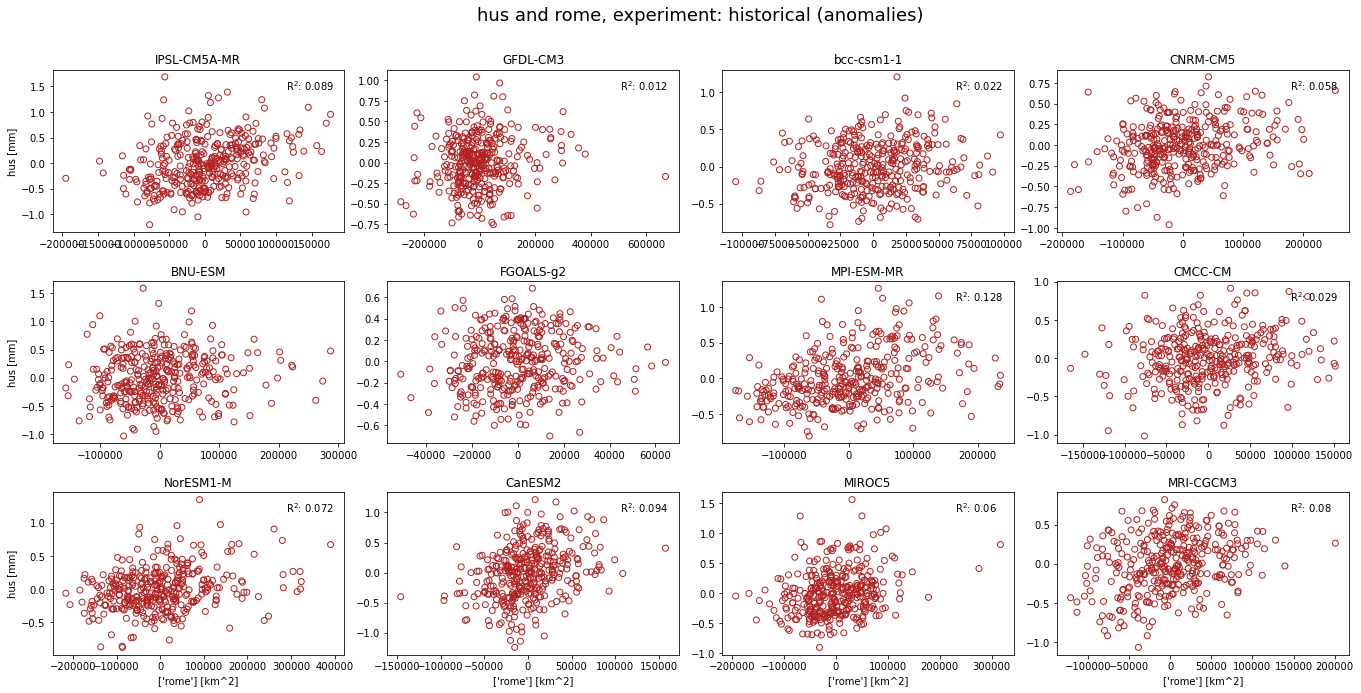

In [53]:
timeMean_options = [
    'monthly',
    ]

quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:

        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        f = resample_timeMean(org, timeMean_options[0])
        climatology = f.groupby('time.month').mean('time')
        x = f.groupby('time.month') - climatology 

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))

    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:

        ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
        data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
        g = 9.8
        data = xr.DataArray(
            data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
            dims=['time', 'lat', 'lon'],
            coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
            attrs={'units':'mm'}
            )
        
        if hus_d:
            wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
            data = data.where(wap500>0, np.nan)

        aWeights = np.cos(np.deg2rad(data.lat))
        f = data.weighted(aWeights).mean(dim=('lat','lon')) 
        f = resample_timeMean(f, timeMean_options[0])
        climatology = f.groupby('time.month').mean('time')
        y = f.groupby('time.month') - climatology 

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))

    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} and {}, experiment: {} (anomalies)'.format(data_options[0], org_options[0], experiments[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    f = resample_timeMean(org, timeMean_options[0])
    climatology = f.groupby('time.month').mean('time')
    x = f.groupby('time.month') - climatology 

    ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
    data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
    g = 9.8
    data = xr.DataArray(
        data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
        dims=['time', 'lat', 'lon'],
        coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
        attrs={'units':'mm'}
        )
    
    if hus_d:
        wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
        data = data.where(wap500>0, np.nan)

    aWeights = np.cos(np.deg2rad(data.lat))
    f = data.weighted(aWeights).mean(dim=('lat','lon')) 
    f = resample_timeMean(f, timeMean_options[0])
    climatology = f.groupby('time.month').mean('time')
    y = f.groupby('time.month') - climatology 

    plot_scatter(x, y , ax, 'firebrick')
    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{}]'.format(org_options, org.units)
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], data.units)
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

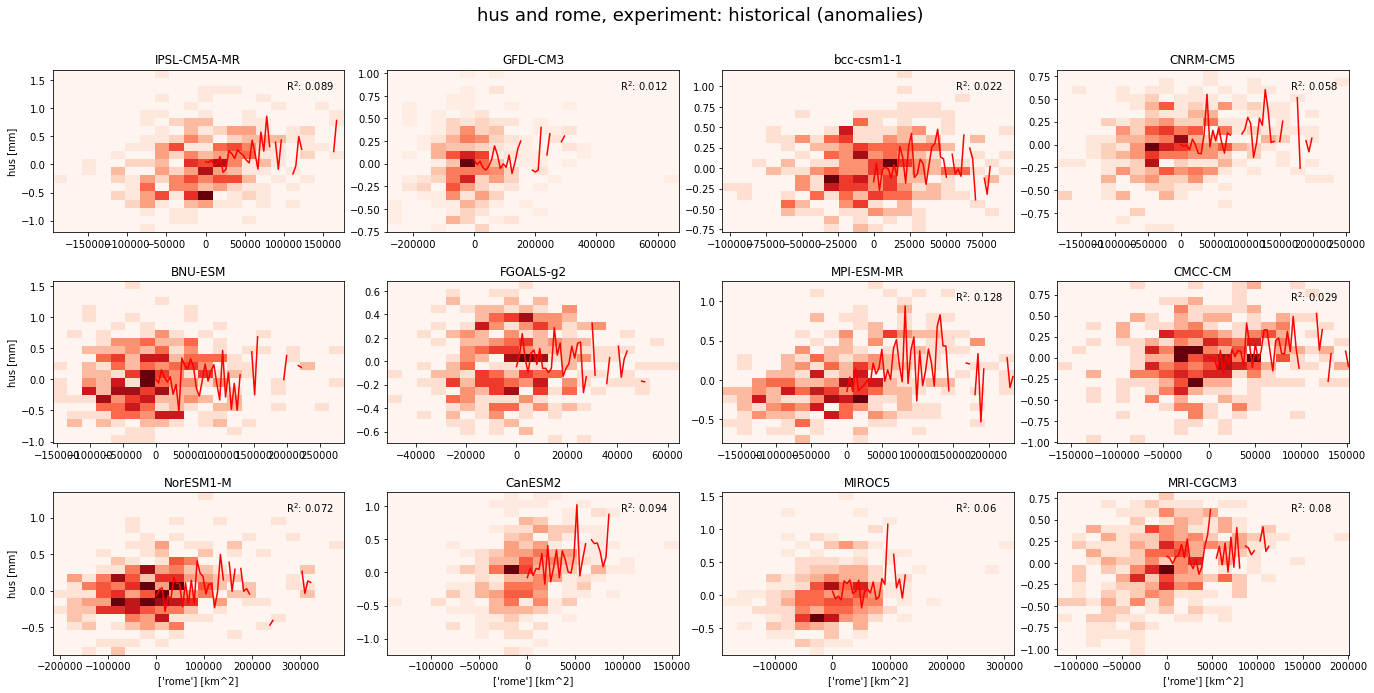

In [54]:
timeMean_options = [
    'monthly',
    ]

quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:

        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        f = resample_timeMean(org, timeMean_options[0])
        climatology = f.groupby('time.month').mean('time')
        x = f.groupby('time.month') - climatology 

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))

    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:

        ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
        data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
        g = 9.8
        data = xr.DataArray(
            data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
            dims=['time', 'lat', 'lon'],
            coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
            attrs={'units':'mm'}
            )
        
        if hus_d:
            wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
            data = data.where(wap500>0, np.nan)

        aWeights = np.cos(np.deg2rad(data.lat))
        f = data.weighted(aWeights).mean(dim=('lat','lon')) 
        f = resample_timeMean(f, timeMean_options[0])
        climatology = f.groupby('time.month').mean('time')
        y = f.groupby('time.month') - climatology 

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))

    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = '{} and {}, experiment: {} (anomalies)'.format(data_options[0], org_options[0], experiments[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    f = resample_timeMean(org, timeMean_options[0])
    climatology = f.groupby('time.month').mean('time')
    x = f.groupby('time.month') - climatology 

    ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
    data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
    g = 9.8
    data = xr.DataArray(
        data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
        dims=['time', 'lat', 'lon'],
        coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
        attrs={'units':'mm'}
        )
    
    if hus_d:
        wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
        data = data.where(wap500>0, np.nan)

    aWeights = np.cos(np.deg2rad(data.lat))
    f = data.weighted(aWeights).mean(dim=('lat','lon')) 
    f = resample_timeMean(f, timeMean_options[0])
    climatology = f.groupby('time.month').mean('time')
    y = f.groupby('time.month') - climatology 

    plt.hist2d(x,y,[20,20], cmap = 'Reds') #, vmin=0, vmax=300)
    plot_bins(x,y, ax, 'r')
    
    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = '{} [{}]'.format(org_options, org.units)
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], data.units)
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

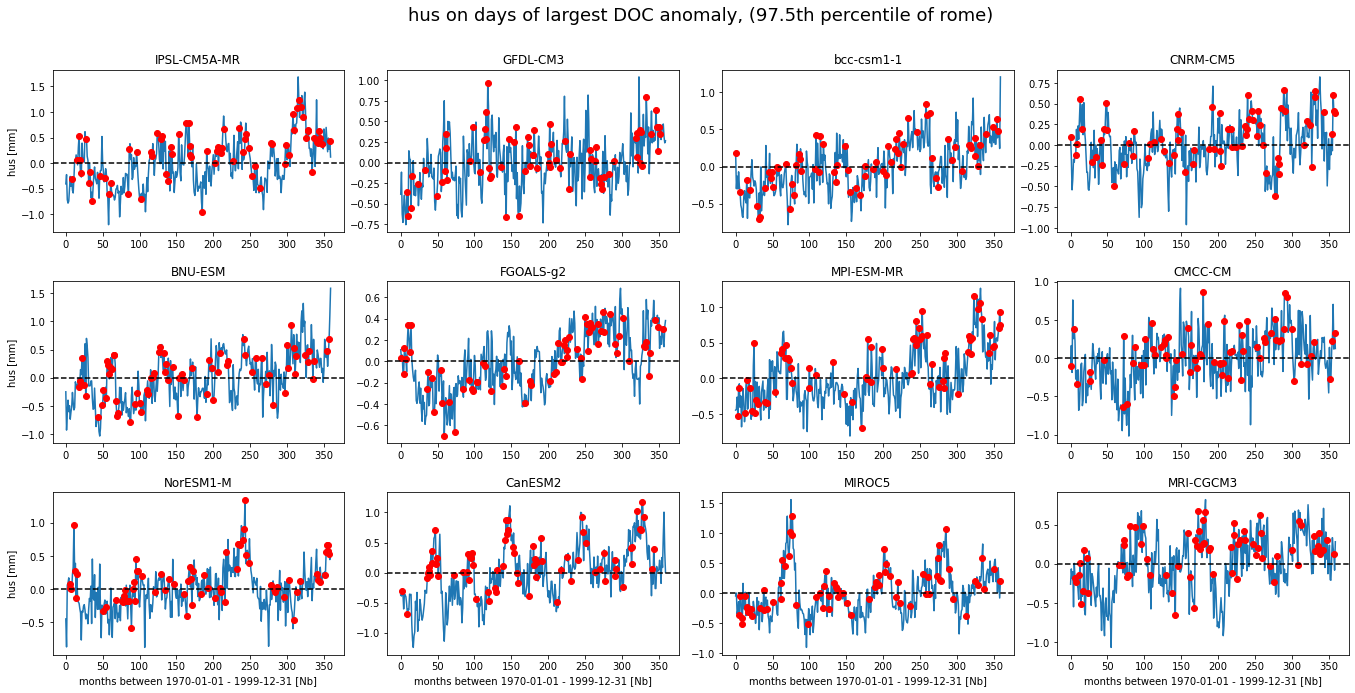

In [55]:
timeMean_options = [
    'monthly',
    ]

quantile_low = 0
quantile_high = 1

absolute_xlimits = False
if absolute_xlimits:
    xmin, xmax = [], []
    for dataset in datasets:

        org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
        f = resample_timeMean(org, timeMean_options[0])
        climatology = f.groupby('time.month').mean('time')
        x = f.groupby('time.month') - climatology 

        xmin = np.append(xmin, np.quantile(x, quantile_low))
        xmax = np.append(xmax, np.quantile(x, quantile_high))

    xmin = np.min(xmin)
    xmax = np.max(xmax)
else:
    xmin, xmax = None, None 


absolute_ylimits = False
if absolute_ylimits:
    ymin, ymax = [], []
    for dataset in datasets:

        ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
        data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
        g = 9.8
        data = xr.DataArray(
            data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
            dims=['time', 'lat', 'lon'],
            coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
            attrs={'units':'mm'}
            )
        
        if hus_d:
            wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
            data = data.where(wap500>0, np.nan)

        aWeights = np.cos(np.deg2rad(data.lat))
        f = data.weighted(aWeights).mean(dim=('lat','lon')) 
        f = resample_timeMean(f, timeMean_options[0])
        climatology = f.groupby('time.month').mean('time')
        y = f.groupby('time.month') - climatology 

        ymin = np.append(ymin, np.quantile(y, quantile_low))
        ymax = np.append(ymax, np.quantile(y, quantile_high))

    ymin = np.min(ymin)
    ymax = np.max(ymax)
else:
    ymin, ymax = None, None 


fig= plt.figure(figsize=(22.5,17.5))
title = 'hus on days of largest DOC anomaly, ({}th percentile of {})'.format(str(x_threshold), org_options[0])

fig.suptitle(title, fontsize=18, y=0.95)

for i, dataset in enumerate(datasets):
    ax= fig.add_subplot(5,4,i+1)
    title = dataset

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    f = resample_timeMean(org, timeMean_options[0])
    climatology = f.groupby('time.month').mean('time')
    x = f.groupby('time.month') - climatology 

    ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
    data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
    g = 9.8
    data = xr.DataArray(
        data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
        dims=['time', 'lat', 'lon'],
        coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
        attrs={'units':'mm'}
        )
    
    if hus_d:
        wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
        data = data.where(wap500>0, np.nan)

    aWeights = np.cos(np.deg2rad(data.lat))
    f = data.weighted(aWeights).mean(dim=('lat','lon')) 
    f = resample_timeMean(f, timeMean_options[0])
    climatology = f.groupby('time.month').mean('time')
    y = f.groupby('time.month') - climatology 

    x_threshold = 80
    x_prctile = np.percentile(x, x_threshold)
    x_org= np.squeeze(np.argwhere(x.data>=x_prctile)) # positive anomalies are where DOC exceed the monthly mean

    x_data= np.arange(0,len(y))

    label = 'Included in {}th percentile {}'.format(str(x_threshold), org_options[0])

    ax.plot(x_data,y, zorder=0,label=data_options[0])
    ax.scatter(x_org, y[x_org], label=label, color='r')
    ax.axhline(y=np.mean(y), color='k', linestyle = '--')

    plt.title(dataset)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    if (len(datasets)-i)<=4:
        xlabel = 'months between ' + str(data.coords['time'][0].values)[:10] +' - '+ str(data.coords['time'][-1].values)[:10] + ' [Nb]'
        plt.xlabel(xlabel)

    if i== 0 or i==4 or i==8 or i==12 or i==16:
        ylabel = '{} [{}]'.format(data_options[0], data.units)
        plt.ylabel(ylabel)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.3)

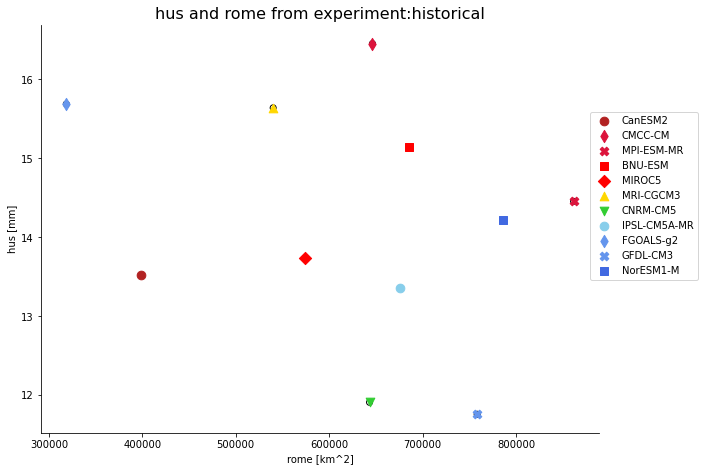

In [61]:
labels =[
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3 no wap data
    'bcc-csm1-1',   # 4 no wao rcp
    'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 no wap data
    # 'HadGEM2-AO',   # 7 no wap data, no hus rcp data
    'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9 no wap data, no hus
    'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    'CMCC-CM',      # 12
    # 'inmcm4',       # 13 no wap data
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17 no wap data
    'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19 no wap data, no hus data
    ]

colors = [
    'firebrick','crimson', 'crimson','red', 'red', # red
    'gold', # yellow
    'limegreen', # green
    'skyblue', 'cornflowerblue', 'cornflowerblue', 'royalblue', 'royalblue' # blue
    ]

markers = ['o','d','X','s','D', '^','v']

order_by_tas = True
if order_by_tas:
    order_list = []
    for dataset in datasets:
        if dataset == 'GPCP':
            order_list = np.append(order_list, 0)
        else:
            data = get_metric('tas_tMean', dataset, experiment=experiments[0])['tas_tMean']
            aWeights = np.cos(np.deg2rad(data.lat))
            tas = data.weighted(aWeights).mean(dim=('lat','lon'))
            order_list = np.append(order_list, tas)
    order = np.argsort(order_list)[::-1]
else:
    order = np.arange(len(datasets), dtype=int)
    colors.reverse()


x= []
y= []
for dataset in datasets:

    org = get_metric(org_options[0], dataset, experiments[0], resolution=resolutions[0])[org_options[0]]
    x_data = org.mean(dim=('time'))
    x = np.append(x, x_data)

    ds = get_dsvariable(variable, dataset, experiments[0], resolution=resolutions[0])
    data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
    g = 9.8
    data = xr.DataArray(
        data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
        dims=['time', 'lat', 'lon'],
        coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
        attrs={'units':'mm'}
        )
    
    if hus_d:
        wap500 = get_dsvariable('wap', dataset, experiments[0], resolution=resolutions[0])['wap'].sel(plev = 5e4)
        data = data.where(wap500>0, np.nan)

    aWeights = np.cos(np.deg2rad(data.lat))
    y_data = data.weighted(aWeights).mean(dim=('lat','lon')) .mean(dim='time')
    y = np.append(y, y_data)

fig, ax = plt.subplots()
title = '{} and {} from experiment:{}'.format(data_options[0], org_options[0], experiments[0])
xlabel = '{} [{}]'.format(org_options[0], org.units)
ylabel = '{} [{}]'.format(data_options[0], data.units)

plot_scatter(x,y,ax)

if labels:
    datasets_order = np.array(datasets)[order]
    labels_order = datasets_order[np.isin(datasets_order, np.array(labels))].tolist()
    
    for i, label in enumerate(labels_order):
        dataset_idx= datasets.index(label)
        plt.scatter(x[dataset_idx],y[dataset_idx],c=colors[i], marker = markers[i%7], s=75,  label=label)
    
    plt.legend(bbox_to_anchor=(0.975,0.8))

sns.despine(top=True, right=True, left=False)
plt.title(title, fontsize = 16)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()

### from warming

In [57]:
models = [
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3 no wap data
    # 'bcc-csm1-1',   # 4 no wao rcp
    'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 no wap data
    # 'HadGEM2-AO',   # 7 no wap data, no hus rcp data
    'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9 no wap data, no hus
    'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    'CMCC-CM',      # 12
    # 'inmcm4',       # 13 no wap data
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17 no wap data
    'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19 no wap data, no hus data
    ]

observations = [
    ]

datasets = models + observations

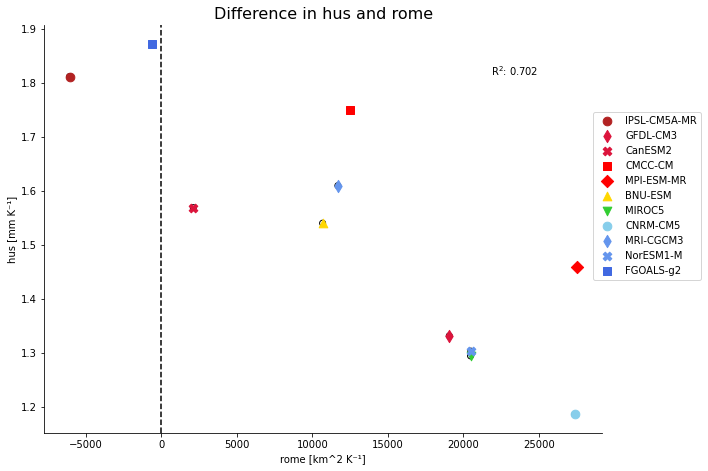

In [62]:
labels =[
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    # 'GISS-E2-H',    # 3 no wap data
    # 'bcc-csm1-1',   # 4 no wao rcp
    'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 no wap data
    # 'HadGEM2-AO',   # 7 no wap data, no hus rcp data
    'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9 no wap data, no hus
    'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    'CMCC-CM',      # 12
    # 'inmcm4',       # 13 no wap data
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17 no wap data
    'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19 no wap data, no hus data
    ]

colors = [
    'firebrick','crimson', 'crimson','red', 'red', # red
    'gold', # yellow
    'limegreen', # green
    'skyblue', 'cornflowerblue', 'cornflowerblue', 'royalblue' # blue
    ]

markers = ['o','d','X','s','D', '^','v']

order_by_tasdiff = True
if order_by_tasdiff:
    order_list = []
    for dataset in datasets:

        if dataset == 'GPCP':
            order_list = np.append(order_list, 0)
        else:
            tas_historical = get_metric('tas_tMean', dataset, experiment='historical')['tas_tMean']
            aWeights = np.cos(np.deg2rad(tas_historical.lat))

            tas_historical = get_metric('tas_tMean', dataset, experiment='historical')['tas_tMean'].weighted(aWeights).mean(dim=('lat','lon'))
            tas_rcp = get_metric('tas_tMean', dataset, experiment='rcp85')['tas_tMean'].weighted(aWeights).mean(dim=('lat','lon'))
            tasdiff = tas_rcp - tas_historical
            order_list = np.append(order_list, tasdiff)
    order = np.argsort(order_list)[::-1]
else:
    order = np.arange(len(datasets), dtype=int)
    colors.reverse()


x= []
y= []
for dataset in datasets:

    # print(dataset)
    org = get_metric(org_options[0], dataset, experiment = 'historical', resolution=resolutions[0])[org_options[0]]
    x_historical = org.mean(dim=('time'))
    org = get_metric(org_options[0], dataset, experiment = 'rcp85', resolution=resolutions[0])[org_options[0]]
    x_rcp = org.mean(dim=('time'))
    x_data = x_rcp - x_historical

    tas_historical = get_metric('tas_tMean', dataset, experiment='historical')['tas_tMean'].weighted(aWeights).mean(dim=('lat','lon'))
    tas_rcp = get_metric('tas_tMean', dataset, experiment='rcp85')['tas_tMean'].weighted(aWeights).mean(dim=('lat','lon'))
    tasdiff = tas_rcp - tas_historical
    x_data = x_data/tasdiff
    x = np.append(x, x_data)

    ds = get_dsvariable(variable, dataset, experiment = 'historical', resolution=resolutions[0])
    data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
    g = 9.8
    data = xr.DataArray(
        data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
        dims=['time', 'lat', 'lon'],
        coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
        attrs={'units':'mm'}
        )
    if hus_d:
        wap500 = get_dsvariable('wap', dataset, experiment = 'historical', resolution=resolutions[0])['wap'].sel(plev = 5e4)
        data = data.where(wap500>0, np.nan)

    aWeights = np.cos(np.deg2rad(data.lat))
    y_historical = data.weighted(aWeights).mean(dim=('lat','lon')) .mean(dim='time')

    ds = get_dsvariable(variable, dataset, experiment = 'rcp85', resolution=resolutions[0])
    data = ds[data_options[0]].sel(plev=slice(850e2,0)).fillna(0)
    g = 9.8
    data = xr.DataArray(
        data= -scipy.integrate.simpson(data.data, data.plev.data, axis=1, even='last')/g,
        dims=['time', 'lat', 'lon'],
        coords={'time':data.time, 'lat': data.lat.data, 'lon': data.lon.data},
        attrs={'units':'mm'}
        )
    if hus_d:
        wap500 = get_dsvariable('wap', dataset, experiment = 'rcp85', resolution=resolutions[0])['wap'].sel(plev = 5e4)
        data = data.where(wap500>0, np.nan)

    aWeights = np.cos(np.deg2rad(data.lat))
    y_rcp = data.weighted(aWeights).mean(dim=('lat','lon')) .mean(dim='time')

    y_data = y_rcp - y_historical
    y_data = y_data/tasdiff
    
    y = np.append(y, y_data)

fig, ax = plt.subplots()
title = 'Difference in {} and {}'.format(data_options[0], org_options[0])
xlabel = '{} [{}]'.format(org_options[0], org.units + ' K' + chr(0x207B) + chr(0x00B9))
ylabel = '{} [{}]'.format(data_options[0], data.units + ' K' + chr(0x207B) + chr(0x00B9))

plot_scatter(x,y,ax)

if labels:
    datasets_order = np.array(datasets)[order]
    labels_order = datasets_order[np.isin(datasets_order, np.array(labels))].tolist()
    
    for i, label in enumerate(labels_order):
        dataset_idx= datasets.index(label)
        plt.scatter(x[dataset_idx],y[dataset_idx],c=colors[i], marker = markers[i%7], s=75,  label=label)
    
    plt.legend(bbox_to_anchor=(0.975,0.8))

sns.despine(top=True, right=True, left=False)
plt.axvline(0, color= 'k',  linestyle="--")
plt.title(title, fontsize = 16)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()